In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5510363684714048 	 Validation loss: 0.40043208861755114 	 
  1%|          | 574/57400 [01:47<2:48:00,  5.64it/s]
Epoch 2 	 Training loss: 0.3985114825519535 	 Validation loss: 0.3611798690537275 	 
  2%|▏         | 1148/57400 [03:36<2:19:42,  6.71it/s]
Epoch 3 	 Training loss: 0.3678812471052911 	 Validation loss: 0.34096015282606673 	 
  3%|▎         | 1722/57400 [05:23<2:34:25,  6.01it/s]
Epoch 4 	 Training loss: 0.3493491124348773 	 Validation loss: 0.32759570696596374 	 
  4%|▍         | 2296/57400 [07:11<2:42:32,  5.65it/s]
Epoch 5 	 Training loss: 0.33689276796184764 	 Validation loss: 0.3228341477402186 	 
  5%|▌         | 2870/57400 [08:59<2:35:38,  5.84it/s]
Epoch 6 	 Training loss: 0.32429936787807984 	 Validation loss: 0.3164471680835142 	 
  6%|▌         | 3444/57400 [10:46<2:19:45,  6.43it/s]
Epoch 7 	 Training loss: 0.31622426821898914 	 Validation loss: 0.31047823621054826 	 
  7%|▋         | 4018/57400 [12:33<2:39:32,  5.58it/s]
Epoch 8 	 Trai

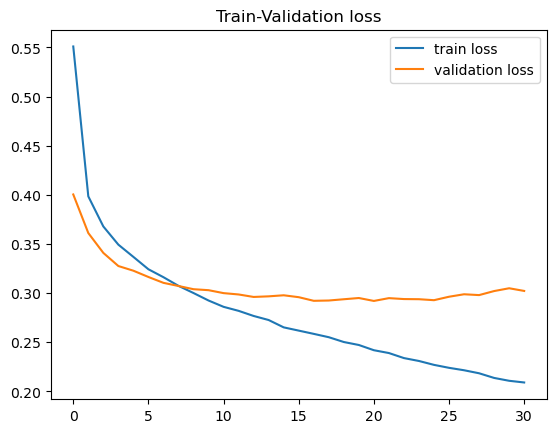

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8647959183673469, 'precision': 0.8647959183673469, 'f1': 0.8647959183673469, 'accuracy': 0.8647959183673469}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.8625, 'precision': 0.8625, 'f1': 0.8625, 'accuracy': 0.8625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7083333333333334, 'precision': 0.7083333333333334, 'f1': 0.7083333333333334, 'accuracy': 0.7083333333333334}
MALE {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6857887874837028, 'precision': 0.6857887874837028, 'f1': 0.6857887874837028, 'accuracy': 0.6857887874837028}
MALE {'recall': 0.7095959595959596, 'precision': 0.7

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5472068299088328 	 Validation loss: 0.3946737298520945 	 
  1%|          | 574/57400 [01:40<2:29:48,  6.32it/s]
Epoch 2 	 Training loss: 0.39483448315269026 	 Validation loss: 0.35161075728424523 	 
  2%|▏         | 1148/57400 [03:20<2:27:58,  6.34it/s]
Epoch 3 	 Training loss: 0.36292144770406265 	 Validation loss: 0.33319451495752495 	 
  3%|▎         | 1722/57400 [05:00<2:32:56,  6.07it/s]
Epoch 4 	 Training loss: 0.3434750103888196 	 Validation loss: 0.32085028795872705 	 
  4%|▍         | 2296/57400 [06:41<2:29:31,  6.14it/s]
Epoch 5 	 Training loss: 0.33072796505502705 	 Validation loss: 0.314542755484581 	 
  5%|▌         | 2870/57400 [08:21<2:49:54,  5.35it/s]
Epoch 6 	 Training loss: 0.3201587852025697 	 Validation loss: 0.31044270754870723 	 
  6%|▌         | 3444/57400 [10:01<2:32:39,  5.89it/s]
Epoch 7 	 Training loss: 0.3111098730346052 	 Validation loss: 0.3066906658774715 	 
  7%|▋         | 4018/57400 [11:41<2:46:34,  5.34it/s]
Epoch 8 	 Train

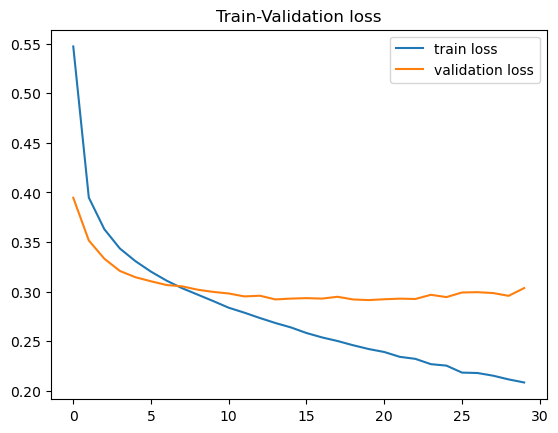

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8622448979591837, 'precision': 0.8622448979591837, 'f1': 0.8622448979591837, 'accuracy': 0.8622448979591837}
MALE {'recall': 0.8697916666666666, 'precision': 0.8697916666666666, 'f1': 0.8697916666666666, 'accuracy': 0.8697916666666666}
FEMALE {'recall': 0.855, 'precision': 0.855, 'f1': 0.855, 'accuracy': 0.855} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7058080808080808, 'precision': 0.7058080808080808, 'f1': 0.7058080808080808, 'accuracy': 0.7058080808080808}
MALE {'recall': 0.7128953771289538, 'precision': 0.7128953771289538, 'f1': 0.7128953771289537, 'accuracy': 0.7128953771289538}
FEMALE {'recall': 0.6981627296587927, 'precision': 0.6981627296587927, 'f1': 0.6981627296587927, 'accuracy': 0.6981627296587927} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6897001303780965, 'precision': 0.6897001303780965, 'f1': 0.6897001303780965, 'accuracy': 0.6897001303780965}
MALE {'recall': 0.70

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5793923601144697 	 Validation loss: 0.401994129863836 	 
  1%|          | 574/57400 [01:39<2:42:19,  5.83it/s]
Epoch 2 	 Training loss: 0.3999387347739748 	 Validation loss: 0.35441050034458355 	 
  2%|▏         | 1148/57400 [03:19<2:41:33,  5.80it/s]
Epoch 3 	 Training loss: 0.3648226254648863 	 Validation loss: 0.335337268093885 	 
  3%|▎         | 1722/57400 [04:59<2:51:37,  5.41it/s]
Epoch 4 	 Training loss: 0.34835701220334614 	 Validation loss: 0.32621403770931695 	 
  4%|▍         | 2296/57400 [06:39<2:31:15,  6.07it/s]
Epoch 5 	 Training loss: 0.3348422917806728 	 Validation loss: 0.3165486240285938 	 
  5%|▌         | 2870/57400 [08:20<2:48:04,  5.41it/s]
Epoch 6 	 Training loss: 0.32249341367740664 	 Validation loss: 0.3134514805624041 	 
  6%|▌         | 3444/57400 [10:00<2:46:56,  5.39it/s]
Epoch 7 	 Training loss: 0.31298290411146673 	 Validation loss: 0.3085395862995568 	 
  7%|▋         | 4018/57400 [11:40<2:11:00,  6.79it/s]
Epoch 8 	 Training

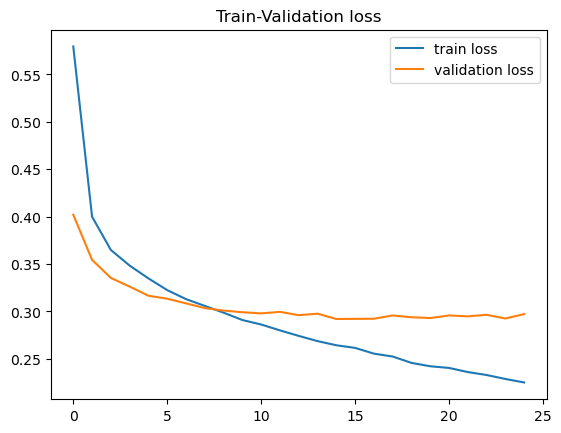

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8596938775510204, 'precision': 0.8596938775510204, 'f1': 0.8596938775510204, 'accuracy': 0.8596938775510204}
MALE {'recall': 0.859375, 'precision': 0.859375, 'f1': 0.859375, 'accuracy': 0.859375}
FEMALE {'recall': 0.86, 'precision': 0.86, 'f1': 0.8599999999999999, 'accuracy': 0.86} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6982323232323232, 'precision': 0.6982323232323232, 'f1': 0.6982323232323232, 'accuracy': 0.6982323232323232}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6949152542372882, 'precision': 0.6949152542372882, 'f1': 0.6949152542372882, 'accuracy': 0.6949152542372882}
MALE {'recall': 0.7070707070707071, 'precision': 0.707

Resultados finales

In [23]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8622448979591837, 'precision': 0.8622448979591837, 'f1': 0.8622448979591837, 'accuracy': 0.8622448979591837}
Métricas etiqueta male: {'recall': 0.8654513888888888, 'precision': 0.8654513888888888, 'f1': 0.8654513888888888, 'accuracy': 0.8654513888888888}
Métricas etiqueta female:  {'recall': 0.8591666666666666, 'precision': 0.8591666666666666, 'f1': 0.8591666666666666, 'accuracy': 0.8591666666666666}

 to
Resultado global: {'recall': 0.7041245791245792, 'precision': 0.7041245791245792, 'f1': 0.7041245791245792, 'accuracy': 0.7041245791245792}
Métricas etiqueta male: {'recall': 0.7137064071370641, 'precision': 0.7137064071370641, 'f1': 0.713706407137064, 'accuracy': 0.7137064071370641}
Métricas etiqueta female:  {'recall': 0.6937882764654418, 'precision': 0.6937882764654418, 'f1': 0.6937882764654418, 'accuracy': 0.6937882764654418}

 as
Resultado global: {'recall': 0.6901347240330291, 'precision': 0.6901347240330291, 'f1': 0.69

# TO

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935622070101496 	 Validation loss: 0.6936279787855634 	 
  1%|          | 574/57400 [01:41<2:33:24,  6.17it/s]
Epoch 2 	 Training loss: 0.6935966446839974 	 Validation loss: 0.6933137461290522 	 
  2%|▏         | 1148/57400 [03:23<2:29:54,  6.25it/s]
Epoch 3 	 Training loss: 0.6933896131424123 	 Validation loss: 0.6928487096802664 	 
  3%|▎         | 1722/57400 [05:03<2:25:09,  6.39it/s]
Epoch 4 	 Training loss: 0.6935644586950229 	 Validation loss: 0.6937443543288667 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:44<2:29:01,  6.16it/s]
Epoch 5 	 Training loss: 0.6933211124524837 	 Validation loss: 0.693002626047296 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:25<2:43:22,  5.56it/s]
Epoch 6 	 Training loss: 0.6933848847495554 	 Validation loss: 0.6925738332635265 	 
  6%|▌         | 3444/57400 [10:05<2:21:29,  6.36it/s]
Epoch 7 	 Training loss: 0.693323679502002 	 Validation loss: 0.6934053018941717 	 

1 epoch without imp

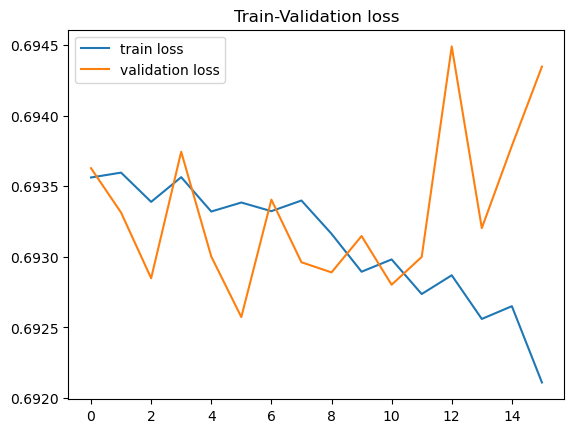

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('roberta_relative_to'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5012755102040817, 'precision': 0.5012755102040817, 'f1': 0.5012755102040817, 'accuracy': 0.5012755102040817}
MALE {'recall': 0.3385416666666667, 'precision': 0.3385416666666667, 'f1': 0.3385416666666667, 'accuracy': 0.3385416666666667}
FEMALE {'recall': 0.6575, 'precision': 0.6575, 'f1': 0.6575, 'accuracy': 0.6575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48484848484848486, 'precision': 0.48484848484848486, 'f1': 0.48484848484848486, 'accuracy': 0.48484848484848486}
MALE {'recall': 0.35036496350364965, 'precision': 0.35036496350364965, 'f1': 0.35036496350364965, 'accuracy': 0.35036496350364965}
FEMALE {'recall': 0.6299212598425197, 'precision': 0.6299212598425197, 'f1': 0.6299212598425197, 'accuracy': 0.6299212598425197} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4980443285528031, 'precision': 0.4980443285528031, 'f1': 0.4980443285528031, 'accuracy': 0.4980443285528031}
MALE {'r

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.696682467589395 	 Validation loss: 0.6932614516403716 	 
  1%|          | 574/57400 [01:40<2:48:06,  5.63it/s]
Epoch 2 	 Training loss: 0.6957250357920285 	 Validation loss: 0.6925894032090397 	 
  2%|▏         | 1148/57400 [03:20<2:36:19,  6.00it/s]
Epoch 3 	 Training loss: 0.6951742815016039 	 Validation loss: 0.692697081525447 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:00<2:28:02,  6.27it/s]
Epoch 4 	 Training loss: 0.6949524644775258 	 Validation loss: 0.693099553302183 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:40<2:34:59,  5.93it/s]
Epoch 5 	 Training loss: 0.6947371746812548 	 Validation loss: 0.6929754028886052 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [08:20<2:15:01,  6.73it/s]
Epoch 6 	 Training loss: 0.6948769705220798 	 Validation loss: 0.6925668504278538 	 
  6%|▌         | 3444/57400 [10:02<2:28:39,  6.05it/s]
Epoch 7 	 Training loss: 0.694524416628615 	 Validation loss: 0.6927448399996

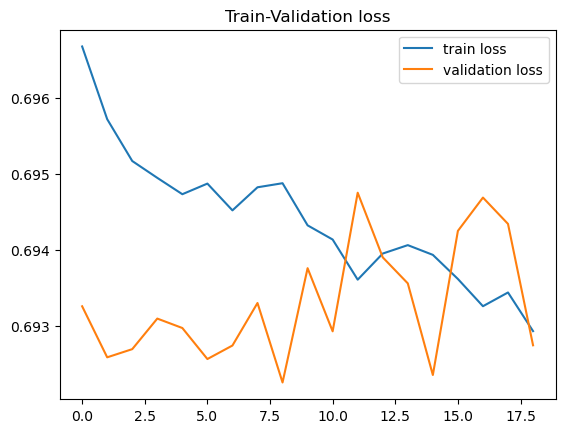

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('roberta_relative_to2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.010416666666666666, 'precision': 0.010416666666666666, 'f1': 0.010416666666666666, 'accuracy': 0.010416666666666666}
FEMALE {'recall': 0.985, 'precision': 0.985, 'f1': 0.985, 'accuracy': 0.985} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4962121212121212, 'precision': 0.4962121212121212, 'f1': 0.4962121212121212, 'accuracy': 0.4962121212121212}
MALE {'recall': 0.046228710462287104, 'precision': 0.046228710462287104, 'f1': 0.046228710462287104, 'accuracy': 0.046228710462287104}
FEMALE {'recall': 0.9816272965879265, 'precision': 0.9816272965879265, 'f1': 0.9816272965879265, 'accuracy': 0.9816272965879265} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935184367442381 	 Validation loss: 0.692855263160447 	 
  1%|          | 574/57400 [01:40<2:18:42,  6.83it/s]
Epoch 2 	 Training loss: 0.6933014788486401 	 Validation loss: 0.6929735955545457 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:22<2:35:57,  6.01it/s]
Epoch 3 	 Training loss: 0.6933253557009149 	 Validation loss: 0.6934997025182692 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:06<2:25:09,  6.39it/s]
Epoch 4 	 Training loss: 0.6932302520250194 	 Validation loss: 0.6925228712922435 	 
  4%|▍         | 2296/57400 [06:50<2:50:30,  5.39it/s]
Epoch 5 	 Training loss: 0.6932316288507774 	 Validation loss: 0.6936209272530119 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:34<2:35:50,  5.83it/s]
Epoch 6 	 Training loss: 0.6930710911127749 	 Validation loss: 0.6930699661626654 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:17<2:31:09,  5.95it/s]
Epoch 7 	 Training loss: 0.6932519716875893 	 

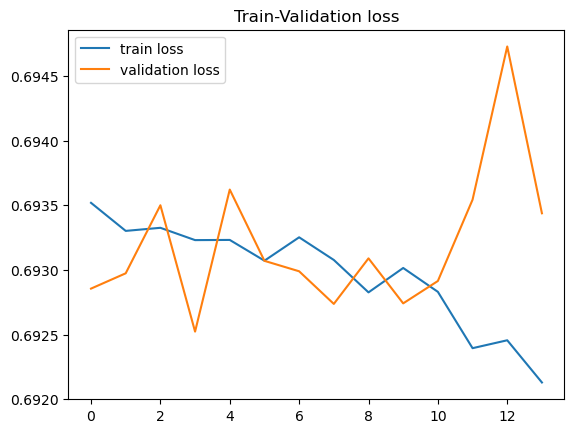

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5318877551020408, 'precision': 0.5318877551020408, 'f1': 0.5318877551020408, 'accuracy': 0.5318877551020408}
MALE {'recall': 0.2109375, 'precision': 0.2109375, 'f1': 0.2109375, 'accuracy': 0.2109375}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.523989898989899, 'precision': 0.523989898989899, 'f1': 0.523989898989899, 'accuracy': 0.523989898989899}
MALE {'recall': 0.2116788321167883, 'precision': 0.2116788321167883, 'f1': 0.2116788321167883, 'accuracy': 0.2116788321167883}
FEMALE {'recall': 0.8608923884514436, 'precision': 0.8608923884514436, 'f1': 0.8608923884514436, 'accuracy': 0.8608923884514436} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5058670143415906, 'precision': 0.5058670143415906, 'f1': 0.5058670143415906, 'accuracy': 0.5058670143415906}
MALE {'recall': 0.18434343434343434, 'precision': 

Resultados finales

In [20]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5136054421768708, 'precision': 0.5136054421768708, 'f1': 0.5136054421768708, 'accuracy': 0.5136054421768708}
Métricas etiqueta male: {'recall': 0.18663194444444445, 'precision': 0.18663194444444445, 'f1': 0.18663194444444445, 'accuracy': 0.18663194444444445}
Métricas etiqueta female:  {'recall': 0.8275, 'precision': 0.8275, 'f1': 0.8274999999999999, 'accuracy': 0.8275}

 to
Resultado global: {'recall': 0.5016835016835017, 'precision': 0.5016835016835017, 'f1': 0.5016835016835017, 'accuracy': 0.5016835016835017}
Métricas etiqueta male: {'recall': 0.20275750202757503, 'precision': 0.20275750202757503, 'f1': 0.20275750202757503, 'accuracy': 0.20275750202757503}
Métricas etiqueta female:  {'recall': 0.8241469816272966, 'precision': 0.8241469816272966, 'f1': 0.8241469816272966, 'accuracy': 0.8241469816272966}

 as
Resultado global: {'recall': 0.4954367666232073, 'precision': 0.4954367666232073, 'f1': 0.4954367666232073, 'accuracy':

# AS

In [21]:
learning_rate = 1e-6
num_epochs = 100
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960022843050209 	 Validation loss: 0.6922485596042568 	 
  1%|          | 574/57400 [01:38<2:32:29,  6.21it/s]
Epoch 2 	 Training loss: 0.6939825688712689 	 Validation loss: 0.6915456400079242 	 
  2%|▏         | 1148/57400 [03:15<2:42:18,  5.78it/s]
Epoch 3 	 Training loss: 0.6914931445379291 	 Validation loss: 0.69142132896488 	 
  3%|▎         | 1722/57400 [04:53<2:24:53,  6.40it/s]
Epoch 4 	 Training loss: 0.6893383126433302 	 Validation loss: 0.6910836433960219 	 
  4%|▍         | 2296/57400 [06:31<2:24:05,  6.37it/s]
Epoch 5 	 Training loss: 0.687539290779559 	 Validation loss: 0.6908333523798798 	 
  5%|▌         | 2870/57400 [08:09<2:22:54,  6.36it/s]
Epoch 6 	 Training loss: 0.6849430226282791 	 Validation loss: 0.6900587364778681 	 
  6%|▌         | 3444/57400 [09:47<2:33:52,  5.84it/s]
Epoch 7 	 Training loss: 0.684200265058657 	 Validation loss: 0.6915911294646182 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [11:25<2:15:12,  6.58it

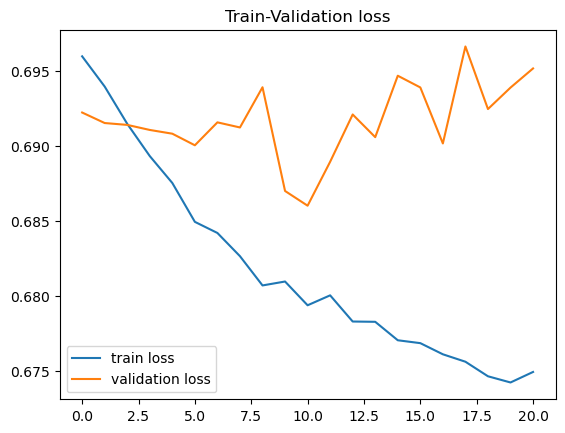

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('roberta_relative_as'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6122448979591837, 'precision': 0.6122448979591837, 'f1': 0.6122448979591837, 'accuracy': 0.6122448979591837}
MALE {'recall': 0.6067708333333334, 'precision': 0.6067708333333334, 'f1': 0.6067708333333334, 'accuracy': 0.6067708333333334}
FEMALE {'recall': 0.6175, 'precision': 0.6175, 'f1': 0.6175, 'accuracy': 0.6175} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7361111111111112, 'precision': 0.7361111111111112, 'f1': 0.7361111111111113, 'accuracy': 0.7361111111111112}
MALE {'recall': 0.781021897810219, 'precision': 0.781021897810219, 'f1': 0.781021897810219, 'accuracy': 0.781021897810219}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.8148631029986962, 'precision': 0.8148631029986962, 'f1': 0.8148631029986962, 'accuracy': 0.8148631029986962}
MALE {'recall': 0.77

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939590092527742 	 Validation loss: 0.6927817726539354 	 
  1%|          | 574/57400 [01:38<2:23:35,  6.60it/s]
Epoch 2 	 Training loss: 0.6932532086397297 	 Validation loss: 0.6916825811741716 	 
  2%|▏         | 1148/57400 [03:15<2:34:21,  6.07it/s]
Epoch 3 	 Training loss: 0.6901121837336842 	 Validation loss: 0.6901993418143968 	 
  3%|▎         | 1722/57400 [04:54<2:46:09,  5.59it/s]
Epoch 4 	 Training loss: 0.6874971721022802 	 Validation loss: 0.6889983203451512 	 
  4%|▍         | 2296/57400 [06:32<2:12:04,  6.95it/s]
Epoch 5 	 Training loss: 0.6843052016318052 	 Validation loss: 0.6895839359800694 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:10<2:39:17,  5.71it/s]
Epoch 6 	 Training loss: 0.682840615926304 	 Validation loss: 0.6928127852536864 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:47<2:21:52,  6.34it/s]
Epoch 7 	 Training loss: 0.68103200830649 	 Validation loss: 0.6913260948860039 	 

3 epoch without impr

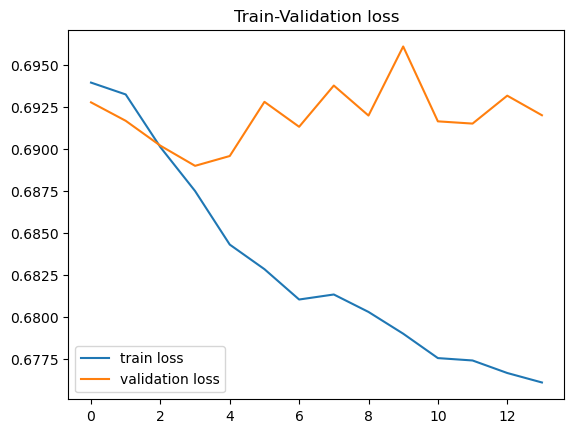

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.7334183673469388, 'precision': 0.7334183673469388, 'f1': 0.7334183673469389, 'accuracy': 0.7334183673469388}
MALE {'recall': 0.7135416666666666, 'precision': 0.7135416666666666, 'f1': 0.7135416666666666, 'accuracy': 0.7135416666666666}
FEMALE {'recall': 0.7525, 'precision': 0.7525, 'f1': 0.7525, 'accuracy': 0.7525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7474747474747475, 'precision': 0.7474747474747475, 'f1': 0.7474747474747475, 'accuracy': 0.7474747474747475}
MALE {'recall': 0.7396593673965937, 'precision': 0.7396593673965937, 'f1': 0.7396593673965937, 'accuracy': 0.7396593673965937}
FEMALE {'recall': 0.7559055118110236, 'precision': 0.7559055118110236, 'f1': 0.7559055118110235, 'accuracy': 0.7559055118110236} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7992177314211213, 'precision': 0.7992177314211213, 'f1': 0.7992177314211213, 'accuracy': 0.7992177314211213}
MALE {'recall': 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693878563335133 	 Validation loss: 0.6934758020659625 	 
  1%|          | 574/57400 [01:37<2:34:25,  6.13it/s]
Epoch 2 	 Training loss: 0.6933192876573223 	 Validation loss: 0.6928110395447683 	 
  2%|▏         | 1148/57400 [03:16<2:59:24,  5.23it/s]
Epoch 3 	 Training loss: 0.6926947405321673 	 Validation loss: 0.6913010619454465 	 
  3%|▎         | 1722/57400 [04:55<2:24:36,  6.42it/s]
Epoch 4 	 Training loss: 0.6893989944291863 	 Validation loss: 0.6898696220527261 	 
  4%|▍         | 2296/57400 [06:33<2:23:30,  6.40it/s]
Epoch 5 	 Training loss: 0.6865184602006387 	 Validation loss: 0.68881113145311 	 
  5%|▌         | 2870/57400 [08:11<2:35:52,  5.83it/s]
Epoch 6 	 Training loss: 0.6853366086084253 	 Validation loss: 0.6895035141605442 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:48<2:17:06,  6.56it/s]
Epoch 7 	 Training loss: 0.6837233778491668 	 Validation loss: 0.6879231374142534 	 
  7%|▋         | 4018/57400 [11:27<2:09:02,  6.89i

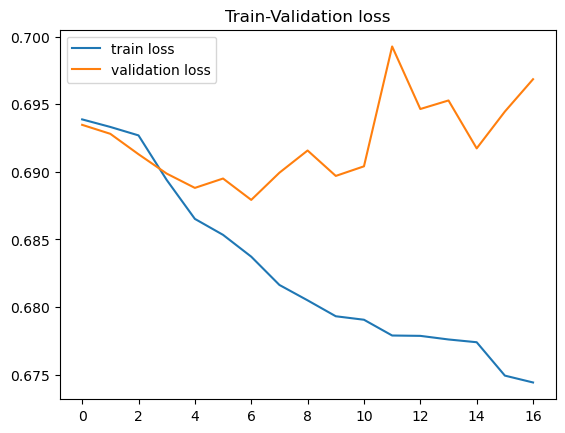

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='roberta_relative_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6441326530612245, 'precision': 0.6441326530612245, 'f1': 0.6441326530612245, 'accuracy': 0.6441326530612245}
MALE {'recall': 0.703125, 'precision': 0.703125, 'f1': 0.703125, 'accuracy': 0.703125}
FEMALE {'recall': 0.5875, 'precision': 0.5875, 'f1': 0.5875, 'accuracy': 0.5875} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.7424242424242424, 'precision': 0.7424242424242424, 'f1': 0.7424242424242424, 'accuracy': 0.7424242424242424}
MALE {'recall': 0.7980535279805353, 'precision': 0.7980535279805353, 'f1': 0.7980535279805353, 'accuracy': 0.7980535279805353}
FEMALE {'recall': 0.6824146981627297, 'precision': 0.6824146981627297, 'f1': 0.6824146981627297, 'accuracy': 0.6824146981627297} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.8226857887874837, 'precision': 0.8226857887874837, 'f1': 0.8226857887874837, 'accuracy': 0.8226857887874837}
MALE {'recall': 0.8257575757575758, 'precision': 0.82575

Resultados finales

In [28]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6632653061224489, 'precision': 0.6632653061224489, 'f1': 0.663265306122449, 'accuracy': 0.6632653061224489}
Métricas etiqueta male: {'recall': 0.6744791666666666, 'precision': 0.6744791666666666, 'f1': 0.6744791666666666, 'accuracy': 0.6744791666666666}
Métricas etiqueta female:  {'recall': 0.6525, 'precision': 0.6525, 'f1': 0.6525, 'accuracy': 0.6525}

 to
Resultado global: {'recall': 0.742003367003367, 'precision': 0.742003367003367, 'f1': 0.7420033670033671, 'accuracy': 0.742003367003367}
Métricas etiqueta male: {'recall': 0.772911597729116, 'precision': 0.772911597729116, 'f1': 0.772911597729116, 'accuracy': 0.772911597729116}
Métricas etiqueta female:  {'recall': 0.7086614173228346, 'precision': 0.7086614173228346, 'f1': 0.7086614173228346, 'accuracy': 0.7086614173228346}

 as
Resultado global: {'recall': 0.8122555410691004, 'precision': 0.8122555410691004, 'f1': 0.8122555410691004, 'accuracy': 0.8122555410691004}
Métrica